Total energy now contains local density-density interactions

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"

data_regime = "rough" # "smooth" or "rough"

N_grid = 100 # number of grid points
if data_regime == "smooth":
    M_cutoff = 5 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + m)**2
elif data_regime == "rough":
    M_cutoff = N_grid # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.0 * m)**2
else:
    raise ValueError("regime must be 'smooth' or 'rough'")

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 200
lr = 1e-3 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training


kernel_regime = "double_Gaussian" # "single_Gaussian" or "double_Gaussian" 
if kernel_regime == "single_Gaussian":
    amp_Gaussian = 1.0 # amplitude of Gaussian kernel for interaction energy
    sigma_Gaussian = 3.0 # width of Gaussian kernel for interaction energy
elif kernel_regime == "double_Gaussian":
    amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
    sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
    amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
    sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy
else:
    raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")

Setup the functional and sample density profiles 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


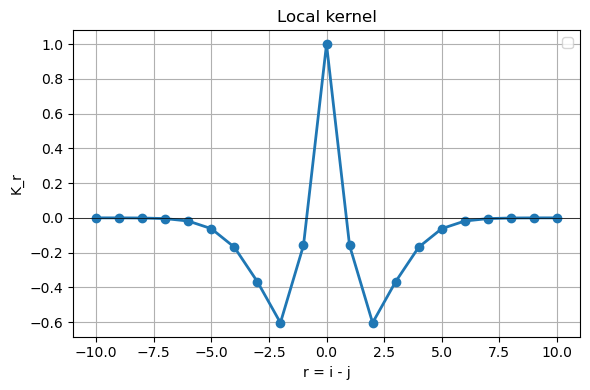

In [31]:
def sample_density(*, rho_b=0.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density has zero mean over the grid points
    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix
    d_rho_a = a @ DerDM  # derivative of rho w.r.t. x

    rho = rho - 0.0 * rho.mean()

    return rho, d_rho_a, a

def sample_density_batch(B: int, rho_b=0.0):
    """
    Sample a batch of B density profiles
    Spatial average density rho_avg is set to zero
    Returns rho: (B, N_grid)
    """

    a = torch.normal(torch.zeros(B, std_harm.numel(),dtype=dtype, device=device), std_harm.expand(B, -1))
    rho = a @ DesignMatrix  # (B, N_grid)
    d_rho_a = a @ DerDM  # (B, N_grid) # derivative of rho w.r.t. x

    rho = rho - 0.0 * rho.mean(dim=1, keepdim=True)
    return rho, d_rho_a, a

# density–density interaction kernels K(r)
# r: tensor (can be negative)
def K_gaussian(r, sigma=1.0):       # strictly local-ish
    r = r.to(dtype=dtype)
    return torch.exp(-(r**2) / (sigma**2))

def K_exp(r, xi=2.0):              # short–to–intermediate range
    r = r.to(dtype=dtype)
    return torch.exp(-torch.abs(r) / xi)

def K_yukawa(r, lam=10.0):         # long-range but screened
    r = torch.abs(r).to(dtype=dtype)
    r = r.clamp(min=1.0)         # avoid r=0 singularity
    return torch.exp(-r / lam) / r

def K_power(r, alpha=1.0):         # unscreened long range (Coulomb-like for alpha=1)
    r = torch.abs(r).to(dtype=dtype)
    r = r.clamp(min=1.0)
    return 1.0 / (r**alpha)

def E_int_conv(rho: torch.Tensor, kernel: str, **kwargs) -> torch.Tensor: 
    """
    Interaction energy using convolution
    rho: (N,) or (B, N)
    kernel: "gaussian", "exp", "yukawa", "power"
    kwargs: parameters for the kernel function (sigma, xi, lam, alpha, etc.)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    if kernel == "gaussian":
        K_fun = K_gaussian
    elif kernel == "exp":
        K_fun = K_exp
    elif kernel == "yukawa":
        K_fun = K_yukawa
    elif kernel == "power":
        K_fun = K_power
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

    # ensure batch dim
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    # r = -(N-1)..(N-1), kernel length = 2N-1
    r_vals = torch.arange(-(N-1), N, device=device, dtype=dtype)  # (2N-1,)
    k_full = K_fun(r_vals, **kwargs)                              # (2N-1,)

    weight = k_full.view(1, 1, -1)                # (1,1,2N-1)
    u = F.conv1d(rho.unsqueeze(1), weight, padding=N-1).squeeze(1) # (B, N)
    E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
    return E.squeeze(0) if E.numel() == 1 else E


if kernel_regime == "single_Gaussian":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return amp_Gaussian * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian)
elif kernel_regime == "double_Gaussian":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return (amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1) +
                amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2))


R = 10 
r_grid = torch.arange(-R, R+1)

plt.figure(figsize=(6,4))
if kernel_regime == "single_Gaussian":
    plt.plot(r_grid, amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian), 'o-', linewidth=2)
elif kernel_regime == "double_Gaussian":
    plt.plot(r_grid, amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2), 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Local kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Feature processing (generation and normalization)

In [32]:
# we save features as (B, N_grid, N_feat), where N_feat is the number of features per grid point
# generate train/test split

def compute_normalization_stats(features):
    """
    Compute mean and std for features with shape (N_data, N_grid, N_feat)
    Averages over both data and spatial dimensions
    
    Args:
        features: torch.Tensor of shape (N_data, N_grid, N_feat)
    
    Returns:
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)
    """

    mean_feat = features.mean(dim=(0, 1), keepdim=True)  # Shape: (1, 1, N_feat)
    std_feat = features.std(dim=(0, 1), keepdim=True) # Shape: (1, 1, N_feat)
    
    return mean_feat, std_feat

def normalize_features(features, mean_feat, std_feat):
    """
    Normalize features using provided or computed statistics
    
    Args:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)

    Returns:
        normalized_features: torch.Tensor of same shape as input
        mean: mean used for normalization
        std: std used for normalization
    """
    normalized_features = (features - mean_feat) / std_feat

    return normalized_features

def generate_loc_features_rs(rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density rho
    rs, real space   
    Args:
        rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form rho^k, k=1,...,N_feat
    """
    features = [rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

def generate_loc_features_ms(d_rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density derivative d_rho
    ms, momentum space
    Args:
        d_rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form d_rho^k, k=1,...,N_feat
    """
    features = [d_rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

rho_train, d_rho_train, a_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test, d_rho_test, a_test = sample_density_batch(N_test)   # (N_test, N_grid)
rho_val, d_rho_val, a_val = sample_density_batch(N_val)    # (N_val, N_grid)

N_feat = 1 

features_train_rs = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_rs  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_rs   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train_ms = generate_loc_features_ms(d_rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_ms  = generate_loc_features_ms(d_rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_ms   = generate_loc_features_ms(d_rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train = torch.cat([features_train_rs, features_train_ms], dim=-1)
features_test  = torch.cat([features_test_rs, features_test_ms], dim=-1)
features_val   = torch.cat([features_val_rs, features_val_ms], dim=-1)

# # Use only real space features, no derivatives
# features_train = features_train_rs
# features_test  = features_test_rs
# features_val   = features_val_rs

targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

Correlation function analysis

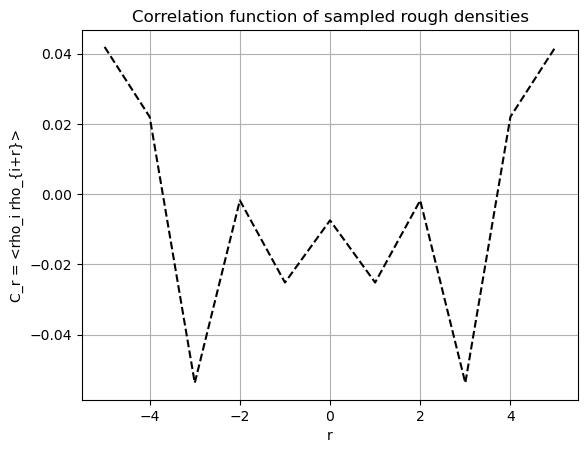

In [ ]:
def dens_dens_corr_func(rho_batch: torch.Tensor, R: int) -> torch.Tensor:
    """
    Compute the correlation function C(r) for each sample in the batch

    Args:
        rho_batch: tensor of shape (B, N)
        R: maximum displacement (integer)

    Returns:
        C: tensor of shape (B, 2R+1)
           C[b, k] = c_b(r) for r = -R + k, k = 0,...,2R
    """
    B, N = rho_batch.shape
    Cs = []

    for r in range(-R, R + 1):
        if r == 0:
            prod = rho_batch * rho_batch / N                       # (B, N)
        elif r > 0:
            # i = 0..N-1-r, i+r = r..N-1
            prod = rho_batch[:, :N - r] * rho_batch[:, r:] / (N - r)    # (B, N-r)
        else:  # r < 0
            k = -r
            # i = k..N-1, i+r = i-k = 0..N-1-k
            prod = rho_batch[:, k:] * rho_batch[:, :N - k] / (N - k)    # (B, N-k)

        C_r = prod.sum(dim=1)                               # (B,)
        Cs.append(C_r)
        
    return torch.stack(Cs, dim=1)

def dens_dens_corr_func_sym(rho_batch: torch.Tensor, R: int) -> torch.Tensor:
    B, N = rho_batch.shape
    Cs = []

    for r in range(0, R + 1):
        if r == 0:
            prod = 0.5 * rho_batch * rho_batch / N                      # (B, N)
        else:
            prod = 0.5 * (rho_batch[:, :N - r] * rho_batch[:, r:] + rho_batch[:, r:] * rho_batch[:, :N - r]) / (N - r)

        C_r = prod.sum(dim=1)                              # (B,)
        Cs.append(C_r)
        
    return torch.stack(Cs, dim=1)


def C_mm(m_vals: torch.Tensor, r_vals: torch.Tensor, N: int) -> torch.Tensor:
    """
    Compute the exact analytic C_mm(r) 

    Args:
        m_vals: (M,) tensor of integer or float modes m
        r_vals: (R,) tensor of integer r values
        N:      number of grid points

    Returns:
        C: (M, R) tensor with C_mm(r)
    """

    m = m_vals.reshape(-1, 1)       # (M,1)
    r = abs(r_vals.reshape(1, -1))       # (1,R)

    theta = math.pi * m / (N - 1)   # (M,1)

    term1 = 0.5 * torch.cos(theta * r)   # (M,R)

    # sin(θ (N-r)) / sin(θ)
    # numerator: sin(pi m (N-r)/(N-1))
    num = torch.sin(theta * (N - r))     # (M,R)
    # denominator: sin(pi m/(N-1))
    den = torch.sin(theta)               # (M,1)

    sign = torch.where((m_vals.to(torch.long) % 2) == 0,
                       torch.tensor(1.0, dtype=m.dtype, device=m.device),
                       torch.tensor(-1.0, dtype=m.dtype, device=m.device))
    sign = sign.view(-1,1)          

    # second term: (0.5/(N-r)) * (-1)^m * num/den
    term2 = 0.5 * sign * (num / den) / (N - r)   # (M,R)

    return term1 + term2


def C_mm_safe(m_vals, r_vals, N):
    C = C_mm(m_vals, r_vals, N)  
    
    # handle m = N-1 specially
    mask_sing = (m_vals == (N-1))
    if mask_sing.any():
        m_idx = torch.nonzero(mask_sing, as_tuple=False).view(-1)
        
        r = torch.abs(r_vals).to(C.dtype).to(C.device)
        pi = torch.acos(torch.zeros(1, dtype=C.dtype, device=C.device)) * 2
        
        C[m_idx, :] = torch.cos(pi * r)  # (-1)^r expressed as cos(pi * r)

    return C


R = 5
N_cycles = 1000
N_batch = 1000
C_avg = torch.zeros(2*R+1, dtype=dtype, device=device)
for cycle in range(N_cycles):

    rho_batch, d_rho_batch, a_batch = sample_density_batch(N_batch)  # (B, N)
    Eng_batch = E_tot(rho_batch)  # (B,)

    C_mat = dens_dens_corr_func(rho_batch, R)  # (B, 2R+1)
    C_avg += C_mat.sum(dim=0)

C_avg /= (N_cycles * N_batch)
C_avg_analytical = ((std_harm**2).unsqueeze(1) * C_mm_safe(m, torch.arange(-R, R+1), N_grid)).sum(dim=0)

r_vals = torch.arange(-R, R+1)
k = 5
# plt.plot(r_vals.cpu(), C_mat[k,:].cpu(), 'o-')
# plt.plot(r_vals.cpu(), C_mat[1,:].cpu(), 'o-')
# plt.plot(r_vals.cpu(), C_mat[2,:].cpu(), 'o-')
# plt.plot(r_vals.cpu(), C_mat[3,:].cpu(), 'o-')
# plt.plot(r_vals.cpu(), C_mat[4,:].cpu(), 'o-')
plt.plot(r_vals.cpu(), C_avg.cpu() - C_avg_analytical.cpu(), 'k--', label="Average")
# plt.plot(r_vals.cpu(), C_avg_analytical.cpu(), 'r--', label="Average (analytical)", alpha=0.5)

# # plt.plot(r_vals.cpu(), C_mat[0,:].cpu() - C_avg.cpu(), 'o-')
# # plt.plot(r_vals.cpu(), C_mat[1,:].cpu() - C_avg.cpu(), 'o-')
# # plt.plot(r_vals.cpu(), C_mat[2,:].cpu() - C_avg.cpu(), 'o-')
# # plt.plot(r_vals.cpu(), C_mat[3,:].cpu() - C_avg.cpu(), 'o-')
# # plt.plot(r_vals.cpu(), C_mat[4,:].cpu() - C_avg.cpu(), 'o-')
plt.xlabel("r")
plt.ylabel("C_r = <rho_i rho_{i+r}>")
if data_regime == "smooth":
    plt.title("Correlation function of sampled smooth densities")
else:
    plt.title("Correlation function of sampled rough densities")
plt.grid(True)
plt.show()


# C_symm_mat = dens_dens_corr_func_sym(rho_batch, R)  # (B, R+1)

# G = C_symm_mat.T @ C_symm_mat / N_batch  # (R+1, R+1)

# U, S, Vt = torch.svd(G) 

# print(S)

# # Compute the kernel vector (linear regression)
# g = (C_symm_mat.T @ Eng_batch) / N_batch
# k_star = torch.linalg.solve(G, g)

# print(k_star)
# def make_symmetric(K_vec: torch.Tensor) -> torch.Tensor:
#     """
#     K_vec: tensor of shape (R+1,) or (R+1, 1) with entries K(0..R)
#     Returns: tensor of shape (2R+1,) with K(-R..R), assuming K(-r) = K(r).
#     """
#     # Make sure it's a 1D tensor
#     if K_vec.ndim > 1:
#         K_vec = K_vec.squeeze()

#     R = K_vec.shape[0] - 1

#     # K(1..R) reversed → negative side
#     K_left  = torch.flip(K_vec[1:], dims=[0])
#     # K(0..R) → non-negative side
#     K_right = K_vec

#     K_full = torch.cat([K_left, K_right], dim=0)  # (2R+1,)
#     return K_full

# k_learned = make_symmetric(k_star)

# R_max = 10
# r_grid = torch.arange(-R_max, R_max+1)

# if kernel_regime == "single_Gaussian":
#     k_true = amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian)
# elif kernel_regime == "double_Gaussian":
#     k_true = (amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) +
#               amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2))
# else:
#     raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")

# plt.figure(figsize=(6,4))
# plt.plot(torch.arange(-R, R+1), k_learned , 'o-', label='Learned kernel', linewidth=2)
# plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)

# plt.axhline(0, color='k', linewidth=0.5)
# plt.xlabel("r = i - j")
# plt.ylabel("K_r")
# plt.title(f"Learned kernel (R = {R})")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
class LearnableKernelConv1d(nn.Module):
    """
    Learnable 1D convolution kernel K_r with range R
    Produces phi = [K * rho] (linear convolution with padding)
    """
    def __init__(self, R=5, even_kernel=True, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.pad_mode = pad_mode
        self.even_kernel = even_kernel
        
        if even_kernel:
            # learn half + center: w[0] (center), w[1..R] (positive r)
            self.kernel_half = nn.Parameter(torch.randn(R+1) * 0.01)
        else:
            # fully unconstrained kernel of size 2R+1
            self.kernel = nn.Parameter(torch.randn(2*R+1) * 0.01)

    def build_kernel(self):
        """
        Returns kernel of shape (1,1,2R+1) as required by conv1d
        """
        if self.even_kernel:
            center = self.kernel_half[0:1]          # (1,)
            pos = self.kernel_half[1:]             # (R,)
            neg = pos.flip(0)               # symmetric
            full = torch.cat([neg, center, pos], dim=0)  # (2R+1,)
        else:
            full = self.kernel
        return full.view(1,1,-1)  # (out=1, in=1, kernel_size)

    def forward(self, rho):
        """
        rho: (B, N_grid)
        Returns: phi: (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        R = self.R
        
        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='constant', value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='reflect')
        else:
            raise ValueError("pad_mode must be zero or reflect")
        
        phi = F.conv1d(x, kernel, padding=0).squeeze(1)
        return phi

class KernelOnlyEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j} = (1 / 2N) * sum_{i} rho_i [K * rho]_i
    The kernel K is assumed local and learnable via convolution
    """

    def __init__(self, R=5):
        super().__init__()
        self.R = R
        self.kernel_conv = LearnableKernelConv1d(R, even_kernel=True, pad_mode="zero")

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        rho_norm = features[..., 0]          # (B, N_grid), isolate density
        rho = rho_norm * std_feat[0,0,0] + mean_feat[0,0,0]  # denormalize density

        # apply learnable convolution kernel
        phi = self.kernel_conv(rho)  # (B, N_grid) # in physical units

        local_energies = 0.5 * rho * phi       # (B, N_grid) # physical units
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,) # physical units
        
        total_energy_norm = (total_energy - E_mean) / E_std  # normalize for training

        return total_energy_norm

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

def load_checkpoint(path, model_class, device="cpu"):
    """
    Loads a saved model checkpoint
    Returns:
        model: reconstructed and loaded model
        normalization: dict of normalization stats
        epoch: best epoch
        val_loss: best validation loss
    """
    ckpt = torch.load(path, map_location=device)
    config = ckpt["config"]
    model = model_class(**config).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    normalization = ckpt.get("normalization", None)
    epoch = ckpt.get("epoch", None)
    val_loss = ckpt.get("val_loss", None)
    return model, normalization, epoch, val_loss
    
def _run_epoch(model, loader, criterion, train: bool):
    if train:
        model.train()
    else:
        model.eval()
    running = 0.0
    n_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if train:
                optimizer.zero_grad()

            total_pred = model(xb)               
            loss = criterion(total_pred, yb)        

            if train:
                loss.backward()
                optimizer.step()

            running += loss.item()
            n_batches += 1

    return running / max(1, n_batches)

def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    max_epochs=10000,
    patience=10,
    min_delta=1e-5,
    ckpt_dir="checkpoints",
    run_name=None,
):
    os.makedirs(ckpt_dir, exist_ok=True)

    best_val = math.inf
    best_state = None
    best_epoch = -1
    since_improved = 0

    hist = {"train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        train_loss = _run_epoch(model, train_loader, criterion, train=True)
        val_loss = _run_epoch(model, val_loader, criterion, train=False)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        improved = (best_val - val_loss) > min_delta
        if improved:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            since_improved = 0

            # save checkpoint with normalization stats
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_best.pt")
            torch.save({
                "model_state_dict": best_state,
                "epoch": best_epoch,
                "val_loss": best_val,
                "config": {
                    "R": model.R,
                },
                "normalization": {
                    "mean_feat": mean_feat.cpu(),
                    "std_feat":  std_feat.cpu(),
                    "E_mean":    E_mean.cpu(),
                    "E_std":     E_std.cpu(),
                    "N_grid":    int(N_grid),
                }
            }, ckpt_path)
        else:
            since_improved += 1

        if (epoch % 10) == 0 or epoch == 1:
            print(f"[{epoch:04d}] train={train_loss:.6f} | val={val_loss:.6f} "
                  f"| best_val={best_val:.6f} (epoch {best_epoch})")

        if since_improved >= patience:
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch}).")
            break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    csv_path = os.path.join(ckpt_dir, f"{run_name}_history.csv")
    try:
        import csv
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["epoch", "train_loss", "val_loss"])
            for i, (tr, va) in enumerate(zip(hist["train_loss"], hist["val_loss"]), start=1):
                w.writerow([i, tr, va])
    except Exception as e:
        print(f"[warn] could not write CSV: {e}")

    return hist, best_epoch



R_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for R in R_list:

    run_name = f"IntKernel_R{R}_sigma{sigma_Gaussian}" 
    torch.manual_seed(1234) # for reproducibility

    model = KernelOnlyEnergyNN(R=R).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Reduce LR when val loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
    )

    hist, best_epoch = train_with_early_stopping(
        model,
        train_loader,
        val_loader,
        criterion,
        scheduler=scheduler,
        max_epochs=N_epochs,
        patience=patience,
        min_delta=min_delta,
        ckpt_dir="checkpoints",
        run_name=run_name,
    )
        


In [ ]:
import pandas as pd

R = 9
run_name = f"IntKernel_R{R}_sigma{sigma_Gaussian}"

path = f"checkpoints/{run_name}_history.csv"

hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)


In [ ]:
R_best = 0
best_val = math.inf

val_hist = []
learning_hist = []

for R in R_list:
    run_name = f"IntKernel_R{R}_sigma{sigma_Gaussian}" 

    model, normalization, epoch, val_loss = load_checkpoint(f"checkpoints/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

    val_hist.append((R, val_loss))
    learning_hist.append((R, ))

    print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
    if val_loss < best_val:
        best_val = val_loss

        R_best = R

    print(f"Best model: R={R_best}, val_loss={best_val:.6f}")

print("Validation history:")
for R, val_loss in val_hist:
    print(f"R={R}: val_loss={val_loss:.6f}")


import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot([x[0] for x in val_hist], [x[1] for x in val_hist], 'o-', label='Best validation error', linewidth=2)

plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("R (kernel range)")
plt.ylabel("learning error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Evaluate performance of training

In [ ]:

R = 7
run_name = f"IntKernel_R{R}_sigma{sigma_Gaussian}"
model, normalization, epoch, val_loss = load_checkpoint(f"checkpoints/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

with torch.no_grad():
    k_full = model.kernel_conv.build_kernel().view(-1).cpu().numpy() 

r_grid = np.arange(-R, R+1)

if kernel_regime == "single_Gaussian":
    def K_true(r):
        return amp_Gaussian * np.exp(-(r**2) / (sigma_Gaussian**2))
elif kernel_regime == "double_Gaussian":
    def K_true(r):
        return (amp_Gaussian_1 * np.exp(-(r**2) / (sigma_Gaussian_1**2)) +
                amp_Gaussian_2 * np.exp(-(r**2) / (sigma_Gaussian_2**2)))
k_true = K_true(r_grid)


plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full , 'o-', label='Learned kernel', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)

# plt.plot(r_grid, k_full / (abs(k_full[R])), 'o-', label='Learned kernel', linewidth=2)
# plt.plot(r_grid, k_true / (abs(k_true[R])), 's--', label='True kernel', alpha=0.7)

plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.title(f"Learned kernel (R = {R})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
targets_train_norm

plt.figure(figsize=(6,4))
plt.hist(targets_train_norm, bins=50)
plt.xlabel("targets_train_norm")
plt.ylabel("count")
plt.title("Histogram of targets_train_norm")
plt.tight_layout()
plt.show()

In [ ]:
def E_int_conv_discrete(rho: torch.Tensor,
                        k_full: torch.Tensor,
                        R: int) -> torch.Tensor:
    """
    Interaction energy with a finite-range kernel k_full of length 2R+1.
    rho: (N,) or (B, N)
    k_full: (2R+1,)  -- symmetric kernel [K_-R, ..., K_0, ..., K_R]
    R: kernel range
    Returns: (B,) energy
    """
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)  # (1, N)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    k_full = k_full.to(device=device, dtype=dtype)          # (2R+1,)
    weight = k_full.view(1, 1, -1)                          # (1, 1, 2R+1)

    # pad by R on each side for linear convolution with kernel of size 2R+1
    u = F.conv1d(rho.unsqueeze(1), weight, padding=R).squeeze(1)  # (B, N)

    E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
    return E.squeeze(0) if E.numel() == 1 else E


rho_batch, d_rho_batch_analytical, _ = sample_density_batch(32)  # (B, N_grid)

if kernel_regime == "single_Gaussian":
    E_int_batch = amp_Gaussian * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian)
    E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
elif kernel_regime == "double_Gaussian":
    E_int_batch = (amp_Gaussian_1 * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian_1) +
                   amp_Gaussian_2 * E_int_conv(rho_batch, kernel="gaussian", sigma=sigma_Gaussian_2))
    E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
E_int_batch_discrete = E_int_conv_discrete(rho_batch, model.kernel_conv.build_kernel().view(-1), R=model.R)
print("E_int_batch:", E_int_batch)
print("E_int_batch_discrete:", E_int_batch_discrete)

